<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

### Note: Each cell has notes in either comments of markdown cells below.

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [62]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_predict

boston = load_boston()

feature_names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [63]:
#survey data sample
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [64]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column

#find total nulls
X.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [65]:
#get index
X.index

RangeIndex(start=0, stop=506, step=1)

In [66]:
#find total no. of rows and columns
X.shape

(506, 13)

In [67]:
#Get data types of columns. 
#All columns are floats, so there are no incorrect values preventing calculations in any rows.
X.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

In [68]:
#summary statistics
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [69]:
#Get correlations for column comparisons
X.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.199458,0.404471,-0.055295,0.417521,-0.219940,0.350784,-0.377904,0.622029,0.579564,0.288250,-0.377365,0.452220
ZN,-0.199458,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.404471,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055295,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.417521,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219940,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.350784,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.377904,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.622029,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.579564,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


In [70]:
#get no. of unique values in each column of data
X.nunique()

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
dtype: int64

In [71]:
#number of unique values in target column
y.nunique()

MEDV    229
dtype: int64

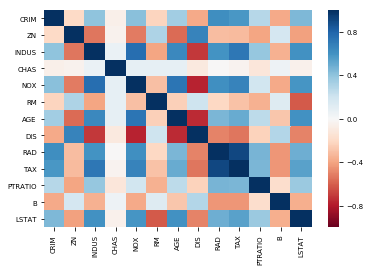

In [72]:
#get visual distributions of all metrics
sns.heatmap(X.corr(),vmin=-1,vmax=1,center=0,cmap='RdBu')

1. CRIM, ZN and RM do not have strong correlation, so we can use them as model features.

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

predictors = ['CRIM','ZN','RM']
X2 = X[predictors]

# create training and testing vars, check shape
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2,random_state=123)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(404, 3) (404, 1)
(102, 3) (102, 1)


In [74]:
# Make an instance of a LinearRegression object.
lr = LinearRegression()
type(lr)

sklearn.linear_model.base.LinearRegression

In [75]:
# help(lr)
help(lr)

Help on LinearRegression in module sklearn.linear_model.base object:

class LinearRegression(LinearModel, sklearn.base.RegressorMixin)
 |  Ordinary least squares Linear Regression.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : boolean, optional, default True
 |      whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (e.g. data is expected to be already centered).
 |  
 |  normalize : boolean, optional, default False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |      subtracting the mean and dividing by the l2-norm.
 |      If you wish to standardize, please use
 |      :class:`sklearn.preprocessing.StandardScaler` before calling ``fit`` on
 |      an estimator with ``normalize=False``.
 |  
 |  copy_X : boolean, optional, default True
 |      If True, X will be copied; else, it may be overwritten.
 |

In [76]:
model = lr.fit(X_train, y_train)
print(lr.intercept_)
print(lr.coef_)

[-29.07849685]
[[-0.23711817  0.04921745  8.2368421 ]]


In [77]:
#assign array with predicted 'y' results to 'y_predicted'
y_predicted = lr.predict(X_test)
y_predicted[:10]

array([[ 6.21577573],
       [25.51816757],
       [36.30947341],
       [14.58634019],
       [33.04166582],
       [42.4171619 ],
       [23.8773199 ],
       [19.62915796],
       [14.83587259],
       [33.73166263]])

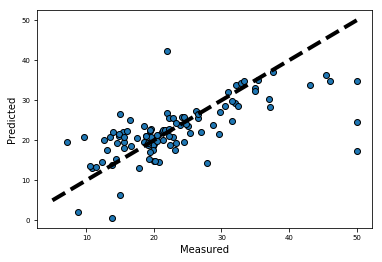

In [78]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_predicted, edgecolors=(0,0,0))
ax.plot([y.min(),y.max()],[y.min(),y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [79]:
from sklearn import metrics

print('Mean-AbsoluteError:', metrics.mean_absolute_error(y_test, y_predicted))
print('Mean-Squared Error:', metrics.mean_squared_error(y_test, y_predicted))
print('Root-Mean-Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))

Mean-AbsoluteError: 4.545149152631587
Mean-Squared Error: 46.98311329031985
Root-Mean-Squared Error: 6.8544228998742005


In [80]:
#print accuracy score of model
print('Score:', model.score(X_test,y_test))
print('Score:', model.score(X_train,y_train))

Score: 0.43213048556210965
Score: 0.5831982601499792


In [81]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
#predicted = cross_val_predict(lr, y_predicted, y_test, cv=10, random_state=123)


#fig, ax = plt.subplots()
#ax.scatter(y_test, predicted, edgecolors=(0,0,0))
#ax.plot([y.min(),y.max()],[y.min(),y.max()], 'k--', lw=4)
#ax.set_xlabel('Measured')
#ax.set_ylabel('Predicted')
#plt.show()

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

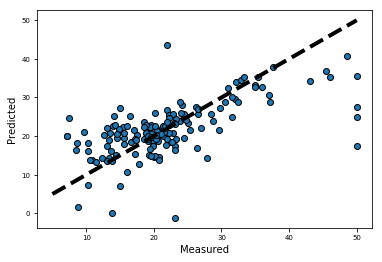

In [82]:
#Model with 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=123)

lr_30 = LinearRegression()

model_30 = lr_30.fit(X_train, y_train)

y_predicted2 = lr_30.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(y_test, y_predicted2, edgecolors=(0,0,0))
ax.plot([y.min(),y.max()],[y.min(),y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [83]:
#score decreased slightly
print('Score:', model_30.score(X_test, y_test))

Score: 0.3862154203683346


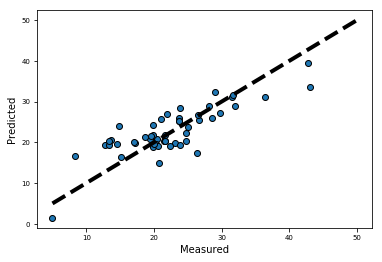

In [84]:
#Model with 90/10 split
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.1)

lr_10 = LinearRegression()

model_10 = lr_10.fit(X_train, y_train)

y_predicted = lr_10.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(y_test, y_predicted, edgecolors=(0,0,0))
ax.plot([y.min(),y.max()],[y.min(),y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [85]:
#score increased
print('Score:', model_10.score(X_test, y_test))

Score: 0.6800152482126798


### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [86]:
# Perform k-fold cross validation with folds from 5 to 10, calculate scores, mean of scores and R-squared
for n in range(5,11):
    scores = cross_val_score(model, X_test, y_test, cv=n)
    print('--------{0}-fold stats --------'.format(n))
    print ('Cross-validated scores:', scores)
    print ('mean of {0}-fold CV scores: {1}'.format(n,np.mean(scores)))
    print("Variance of {0}-fold Cross validation: {1}".format(n,np.var(scores)))
    print('')

--------5-fold stats --------
Cross-validated scores: [ 0.63808188  0.78010253  0.30499716  0.41999354 -0.35627447]
mean of 5-fold CV scores: 0.35738012809198305
Variance of 5-fold Cross validation: 0.15469099953189908

--------6-fold stats --------
Cross-validated scores: [ 0.68247088  0.74307467  0.46945126 -0.41531086  0.38708936 -0.40635374]
mean of 6-fold CV scores: 0.24340359666313485
Variance of 6-fold Cross validation: 0.2283806243354374

--------7-fold stats --------
Cross-validated scores: [ 0.67622765  0.79381644  0.45398382 -0.52079636  0.05156703 -0.1055848
 -0.45177288]
mean of 7-fold CV scores: 0.128205843389783
Variance of 7-fold Cross validation: 0.2382296305166138

--------8-fold stats --------
Cross-validated scores: [ 0.68242513  0.8158067   0.23373013  0.52274356 -0.82623956  0.42322246
 -2.51206931  0.69608726]
mean of 8-fold CV scores: 0.004463296638298364
Variance of 8-fold Cross validation: 1.1394743258353004

--------9-fold stats --------
Cross-validated score

1. Variance loosely increases with number of folds, while mean of CV scores trends upwards with increase in folds.

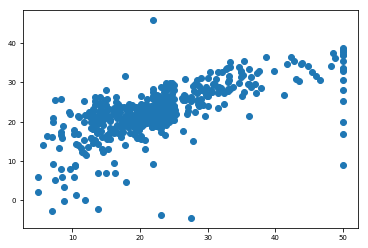

In [87]:
# Make cross validated predictions
predictions = cross_val_predict(model, X2, y, cv=5)
plt.scatter(y, predictions)

# KNN Practice

In [88]:
# Read the iris data into a DataFrame

DATA = r"https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv"
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(DATA, header=None, names=col_names)
iris.drop(iris.index[0], inplace= True)
iris['petal_length'] = iris.petal_length.astype(float, inplace = True)
iris['petal_width'] = iris.petal_width.astype(float, inplace = True)
iris['sepal_length'] = iris.sepal_length.astype(float, inplace = True)
iris['sepal_width'] = iris.sepal_width.astype(float, inplace = True)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [89]:
iris.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

In [90]:
# Increase the default figure and font sizes for easier viewing
import matplotlib.ticker as ticker

plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['font.size'] = 14
plt.rcParams["xtick.labelsize"] = 7
plt.rcParams["ytick.labelsize"] = 7

In [91]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [92]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
species_map = {'setosa':0,'versicolor':1,'virginica':2}
iris['species_num'] = iris['species'].map(species_map)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_num
1,5.1,3.5,1.4,0.2,setosa,0
2,4.9,3.0,1.4,0.2,setosa,0
3,4.7,3.2,1.3,0.2,setosa,0
4,4.6,3.1,1.5,0.2,setosa,0
5,5.0,3.6,1.4,0.2,setosa,0


In [93]:
iris.corr()

,sepal_length,sepal_width,petal_length,petal_width,species_num
sepal_length,1.000000,-0.109369,0.871754,0.817954,0.782561
sepal_width,-0.109369,1.000000,-0.420516,-0.356544,-0.419446
petal_length,0.871754,-0.420516,1.000000,0.962757,0.949043
petal_width,0.817954,-0.356544,0.962757,1.000000,0.956464
species_num,0.782561,-0.419446,0.949043,0.956464,1.000000


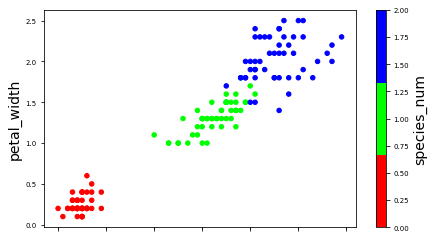

In [94]:
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
iris.plot(kind='scatter', x='petal_length', y='petal_width', c='species_num', colormap=cmap_bold);

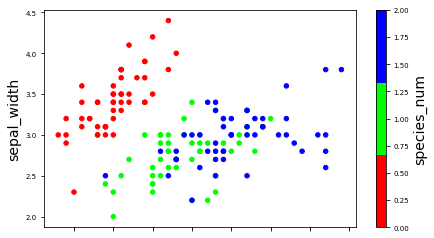

In [95]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
iris.plot(kind='scatter', x='sepal_length', y='sepal_width', c='species_num', colormap=cmap_bold);

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [96]:
predictors = ['sepal_length','sepal_width','petal_length']
X = iris[predictors]

### Create your target vector "y"
This will be the species type.

In [97]:
#assigned 'y' as an array to address data conversion error 
#y=iris['species_num']
y=np.ravel(iris['species'])

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=123)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(135, 3) (135,)
(15, 3) (15,)


### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [99]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
type(neigh)

sklearn.neighbors.classification.KNeighborsClassifier

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [100]:
k_model = neigh.fit(X_train, y_train)
predicted = neigh.predict(X_test)
predicted

array(['virginica', 'virginica', 'virginica', 'versicolor', 'setosa',
       'virginica', 'versicolor', 'setosa', 'setosa', 'versicolor',
       'versicolor', 'setosa', 'versicolor', 'virginica', 'virginica'],
      dtype=object)

In [101]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, predicted)
print('model accuracy for 1 neighbour is', acc)

model accuracy for 1 neighbour is 0.8666666666666667


### Create a Model With Five Neighbors. Did it Improve?

In [102]:
#model accuracy improved slightly
neigh_5 = KNeighborsClassifier(n_neighbors=5)
k_model_5 = neigh_5.fit(X_train, y_train)
predicted_5 = neigh_5.predict(X_test)
acc_5 = accuracy_score(y_test, predicted_5)
print('model accuracy for 5 neighbours is', acc_5)

model accuracy for 5 neighbours is 0.8666666666666667


### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [103]:
#looped function for calculating accuracy for various neighbours
def get_knn(n):
    for n in range(1,n+1):
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train, y_train)
        predicted_knn = knn.predict(X_test)
        acc = accuracy_score(y_test, predicted_knn)
        print('model accuracy for {0} neighbours is {1}'.format(n, acc))

get_knn(10)

model accuracy for 1 neighbours is 0.8666666666666667
model accuracy for 2 neighbours is 0.8
model accuracy for 3 neighbours is 0.8
model accuracy for 4 neighbours is 0.8
model accuracy for 5 neighbours is 0.8666666666666667
model accuracy for 6 neighbours is 0.8
model accuracy for 7 neighbours is 0.8666666666666667
model accuracy for 8 neighbours is 0.8
model accuracy for 9 neighbours is 0.8
model accuracy for 10 neighbours is 0.8


1. Define a function that creates an instance of KNeighbourClassifier with number of nearest neighbours being an interated list of integers from 1 through to argument.
2. Model is fitted with training data
3. predictions are made ontest data, which are then used alongside test targets to calculate accuracy. 
4. print each score and its corresponding number of neighbours
5. We see that accuracy is lower with even number of neighbours.

NOTE: I actually performed the above using all four numerical features, though produced accuracy scores indicating overfitting. Therefore I removed one of the features to achieve the above results.

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

In [104]:
#'knn.predict_proba(X_new)' will return probability estimates for new observations

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [105]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [106]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1220.
Date:                Sat, 29 Sep 2018   Prob (F-statistic):          1.59e-321
Time:                        16:31:57   Log-Likelihood:                -1567.7
No. Observations:                 506   AIC:                             3151.
Df Residuals:                     498   BIC:                             3185.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9744      0.224     22.197      0.000       4.534       5.415
LSTAT         -0.5615      0.048    -11.817      0.000      -0.655      -0.468
RAD            0.2109      0.070      3.025      0.003       0.074       0.348
TAX           -0.0174      0.004     -4.267      0.000      -0.025      -0.009
NOX            4.3456      3.385      1.284      0.200      -2.305      10.997
INDUS          0.0925      0.067      1.385      0.167      -0.039       0.224
CRIM          -0.0866      0.037     -2.362      0.019      -0.159      -0.015
ZN             0.0288      0.013      2.215      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.072   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              831.634
Skew:                           1.665   Prob(JB):                    2.59e-181
Kurtosis:                       8.325   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

In [107]:
from sklearn.linear_model import ElasticNet

X = pd.DataFrame(boston.data,columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['MEDV'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

alpha = 0.4
enet = ElasticNet(alpha=alpha, l1_ratio=1)
enet_model = enet.fit(X_train, y_train)

print(enet.intercept_)
print(enet.coef_)

[26.89872203]
[-0.07631708  0.04737077  0.          0.         -0.          3.34914465
 -0.         -0.94368184  0.23691089 -0.01405669 -0.71106617  0.00705422
 -0.63553537]


I'm choosing to optimise the score by using elastic net, in conjunction with linear regression for predicting MEDV.

1. Fitted an elastic net regression model for all boston features, setting Alpha to 0.4 and l1_ratio to 1 (LASSO).
2. Printed intercept and coefficients to determine removed features
3. By my estimation, features removed correspond to INDUS, CHAS, NOX and AGE.

I played around with the 'alpha' value, arriving at 0.4 as optimal.

In [108]:
print('Training Score:', enet_model.score(X_train,y_train))
print('Test Score:', enet_model.score(X_test,y_test))

Training Score: 0.7400200053897213
Test Score: 0.6336477578895328


1. Compared Accuracies, less than 10% difference - indicates overfitting.

In [109]:
for n in range(5,11):
    scores = cross_val_score(enet, X_test, y_test, scoring="r2", cv=n)
    print('-------- {0}-fold ENet stats --------'.format(n))
    print ('Cross-validated ENet scores:', scores)
    print ('mean of {0}-fold ENet CV scores: {1}'.format(n,np.mean(scores)))
    #print("Variance of {0}-fold Cross validation: {1}".format(n,np.var(scores)))
    print('')

-------- 5-fold ENet stats --------
Cross-validated ENet scores: [0.61715224 0.37119164 0.61496016 0.35057934 0.69148015]
mean of 5-fold ENet CV scores: 0.5290727053003943

-------- 6-fold ENet stats --------
Cross-validated ENet scores: [0.54619989 0.37624915 0.62084496 0.54685765 0.48234432 0.69823227]
mean of 6-fold ENet CV scores: 0.545121373318434

-------- 7-fold ENet stats --------
Cross-validated ENet scores: [0.57527601 0.30853799 0.65403209 0.52710287 0.26253385 0.0915458
 0.82068275]
mean of 7-fold ENet CV scores: 0.46281590937177863

-------- 8-fold ENet stats --------
Cross-validated ENet scores: [0.65960753 0.20181129 0.73932227 0.57875608 0.48208808 0.7140334
 0.15159879 0.84336248]
mean of 8-fold ENet CV scores: 0.5463224908885755

-------- 9-fold ENet stats --------
Cross-validated ENet scores: [0.63057441 0.49413164 0.55487427 0.60936789 0.51902244 0.42531017
 0.11642834 0.58700914 0.77902695]
mean of 9-fold ENet CV scores: 0.523971695037416

-------- 10-fold ENet sta

1. 8 Fold elastic net model appears to have the highest R2 score. From interpretation against initial R2 score from statsmodel, there doesn't seem to be an improvement.

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

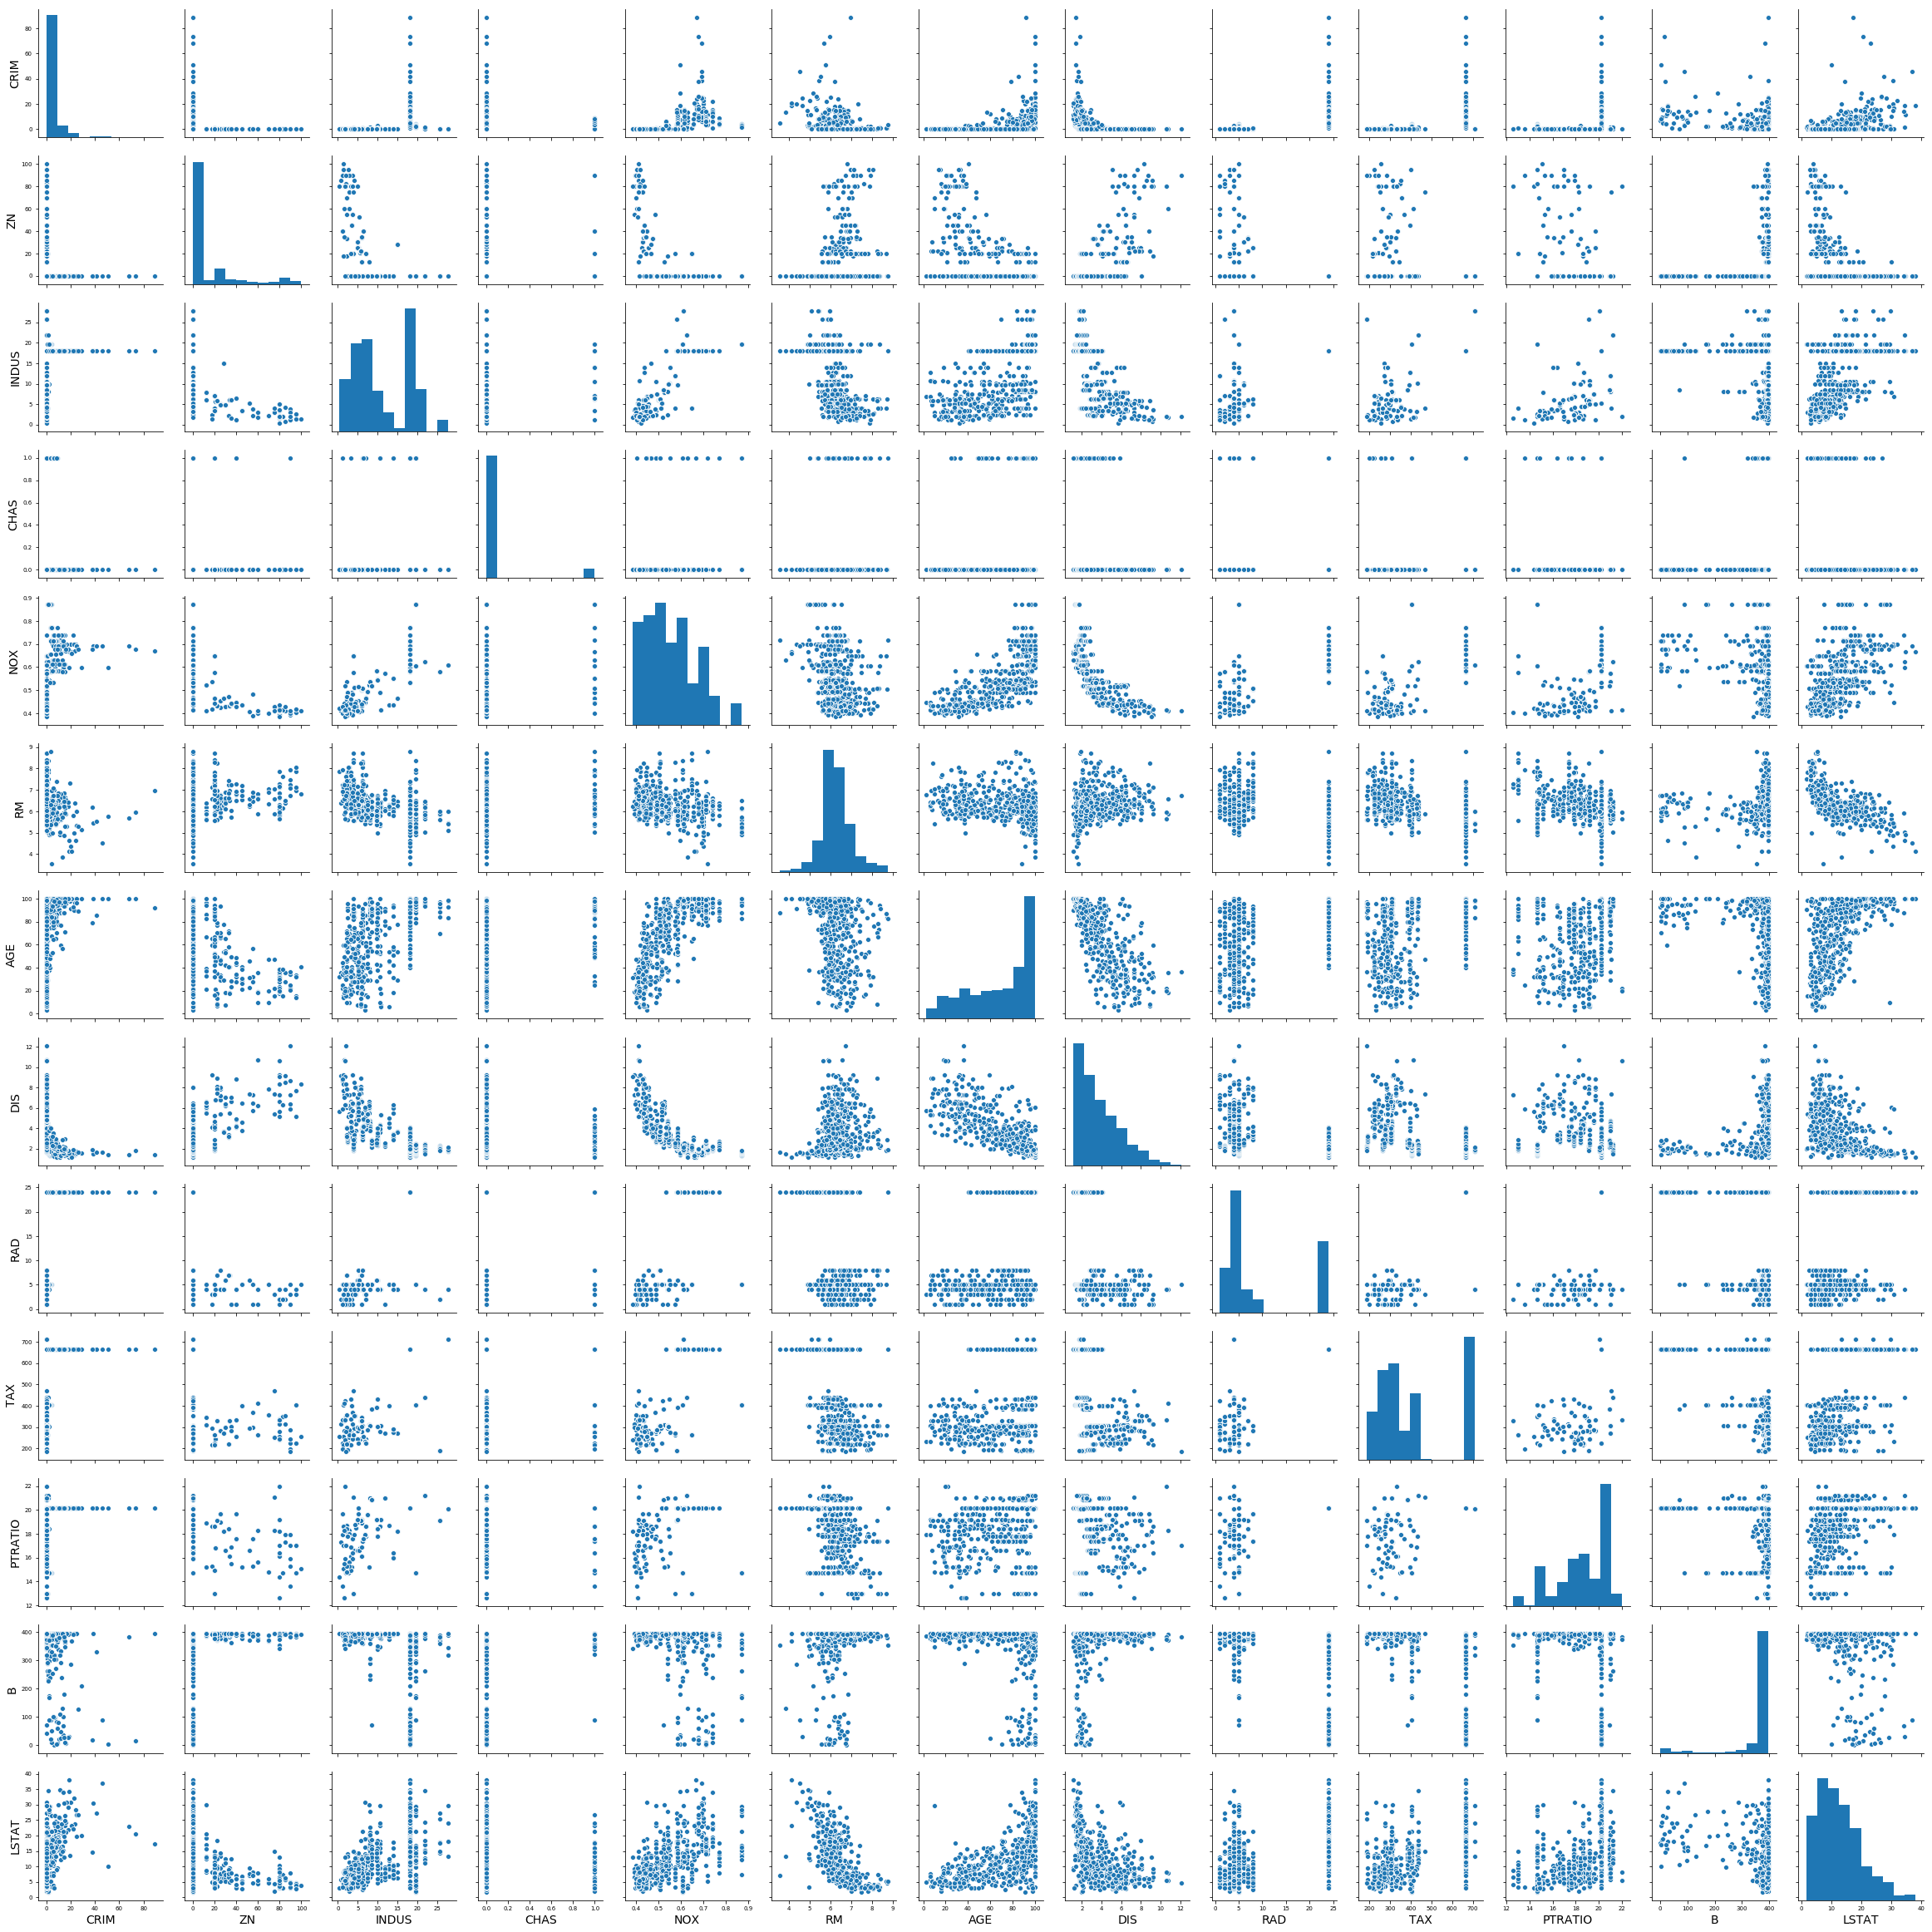

In [110]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [111]:
# Check out Pearson scores

## Demo: Patsy

In [112]:
import patsy

# Add response to the core DataFrame
y = df['MEDV']

In [113]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


/Users/meisan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [114]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: 0.49064879060942257
